## R Notebook for repeated-measures ANOVA lecture

Based on [Crosse et al (2015)](https://www.jneurosci.org/content/35/42/14195.short)

This is an R notebook based on what I used to simulate the data and generate the figures for my lecture on repeated-measures ANOVA. To run the code, click on each block (a "cell") of code and click the "play" button near the top of the page. There is also a button at the top of the page to run all of the cells (the two right arrows, or "fast-forward icon", at the top).

*I originally wrote this script in [Python](https://mybinder.org/v2/gh/natezuk/RM-S2-Stats-Demos/b55130f298fb6f07e55bc51aa58085637571ec0a?urlpath=lab%2Ftree%2Fpsyc20255-rm-s2-statistics-rmanova.ipynb), but I converted it into R with the help of Microsoft Copilot and Claude 3.5 Sonnet.*


In [23]:
# Load necessary libraries
library(tidyverse)
library(reshape2)
library(afex)
library(emmeans)
library(patchwork)
library(car)

# Increase plot size
options(repr.plot.width=12, repr.plot.height=7)

### Generate the data

In [6]:
# Set seed for reproducibility
set.seed(42)

# Number of subjects and levels (conditions)
n_subjects <- 20
levels <- c('AV', 'A', 'V')
n_levels <- length(levels)

# Mean values and standard deviation for each level
means <- c(600, 650, 800)
std_dev_sbj <- 100 # standard deviation across participants
std_dev_wthn <- 30 # standard deviation within participants

# Initialize empty data frame to store results
df <- data.frame(
  Subject = numeric(),
  Condition = character(),
  Response_time = numeric()
)

# Simulate data
for (subject in 1:n_subjects) {
  sbj_avg <- rnorm(1, mean = 0, sd = std_dev_sbj)
  for (level in 1:n_levels) {
    value <- rnorm(1, mean = means[level], sd = std_dev_wthn)
    value <- value + sbj_avg
    
    # Add row to data frame
    df <- rbind(df, data.frame(
      Subject = subject,
      Condition = levels[level],
      Response_time = value
    ))
  }
}

glimpse(df)

Rows: 60
Columns: 3
$ Subject       <int> 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7,…
$ Condition     <chr> "AV", "A", "V", "AV", "A", "V", "AV", "A", "V", "AV", "A…
$ Response_time <dbl> 720.1549, 797.9897, 956.0817, 637.2431, 735.7725, 837.58…


### Plot the data

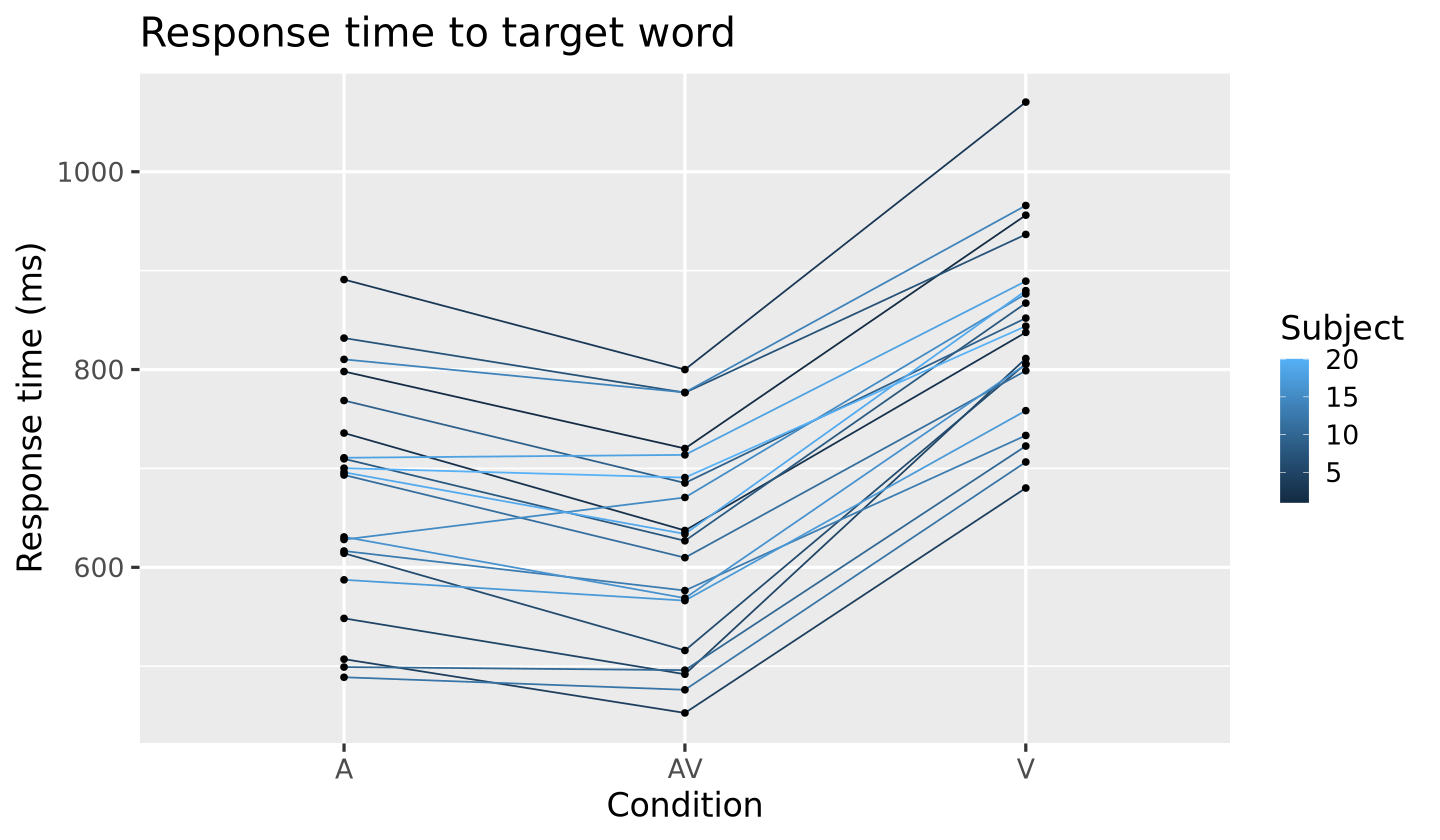

In [24]:
# Plot the data
ggplot(df, aes(x = Condition, y = Response_time, group = Subject)) +
  geom_line(aes(color = Subject)) +
  geom_point() +
  labs(title = "Response time to target word", x = "Condition", y = "Response time (ms)") +
  theme_grey(base_size=20)

### Run the repeated measures ANOVA

In [8]:
# Run the repeated-measures ANOVA
anova_results <- aov_car(Response_time ~ Error(Subject/Condition), data=df)
summary_aov <- summary(anova_results)
summary_aov

Warning message in summary.Anova.mlm(object$Anova, multivariate = FALSE):
“HF eps > 1 treated as 1”



Univariate Type III Repeated-Measures ANOVA Assuming Sphericity

              Sum Sq num Df Error SS den Df F value    Pr(>F)    
(Intercept) 30458102      1   601374     19  962.30 < 2.2e-16 ***
Condition     510790      2    37537     38  258.54 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Mauchly Tests for Sphericity

          Test statistic p-value
Condition        0.93454 0.54374


Greenhouse-Geisser and Huynh-Feldt Corrections
 for Departure from Sphericity

           GG eps Pr(>F[GG])    
Condition 0.93856  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            HF eps  Pr(>F[HF])
Condition 1.037868 7.46439e-23

In [28]:
# Get and display the main information for the within-subjects effect
univar_anova <- summary_aov$univariate.tests
dof1 <- univar_anova[2,'num Df']
dof2 <- univar_anova[2,'den Df']
Fstat <- univar_anova[2,'F value']
pval <- univar_anova[2,'Pr(>F)']

cat(sprintf("Degrees of freedom = (%.0f,%.0f)\n", dof1, dof2))
cat(sprintf("F-statistic = %.2f\n", Fstat))
cat(sprintf("pval = %.3f\n", pval))

Degrees of freedom = (2,38)
F-statistic = 258.54
pval = 0.000


In [26]:
# Calculate the between-subjects sum-of-squares
SS_total <- sum((df$Response_time - mean(df$Response_time))^2)
    # This will be different than what you see in the ANOVA table above. 
    # R displays the sum-of-squares without subtracting the mean. 
    # Calculating the total SS centered on the mean is more standard.
sbj_mean <- aggregate(Response_time ~ Subject, df, mean)
SS_sbj <- sum((sbj_mean$Response_time - mean(df$Response_time))^2) * n_levels
SS_within <- SS_total - SS_sbj

cat(sprintf("Total SS = %.2f\n", SS_total))
cat(sprintf("Between-subject SS = %.2f\n", SS_sbj))
cat(sprintf("Within-subject SS = %.2f\n", SS_within))

Total SS = 1149701.66
Between-subject SS = 601374.31
Within-subject SS = 548327.36


### Demonstration of calculating the p-value

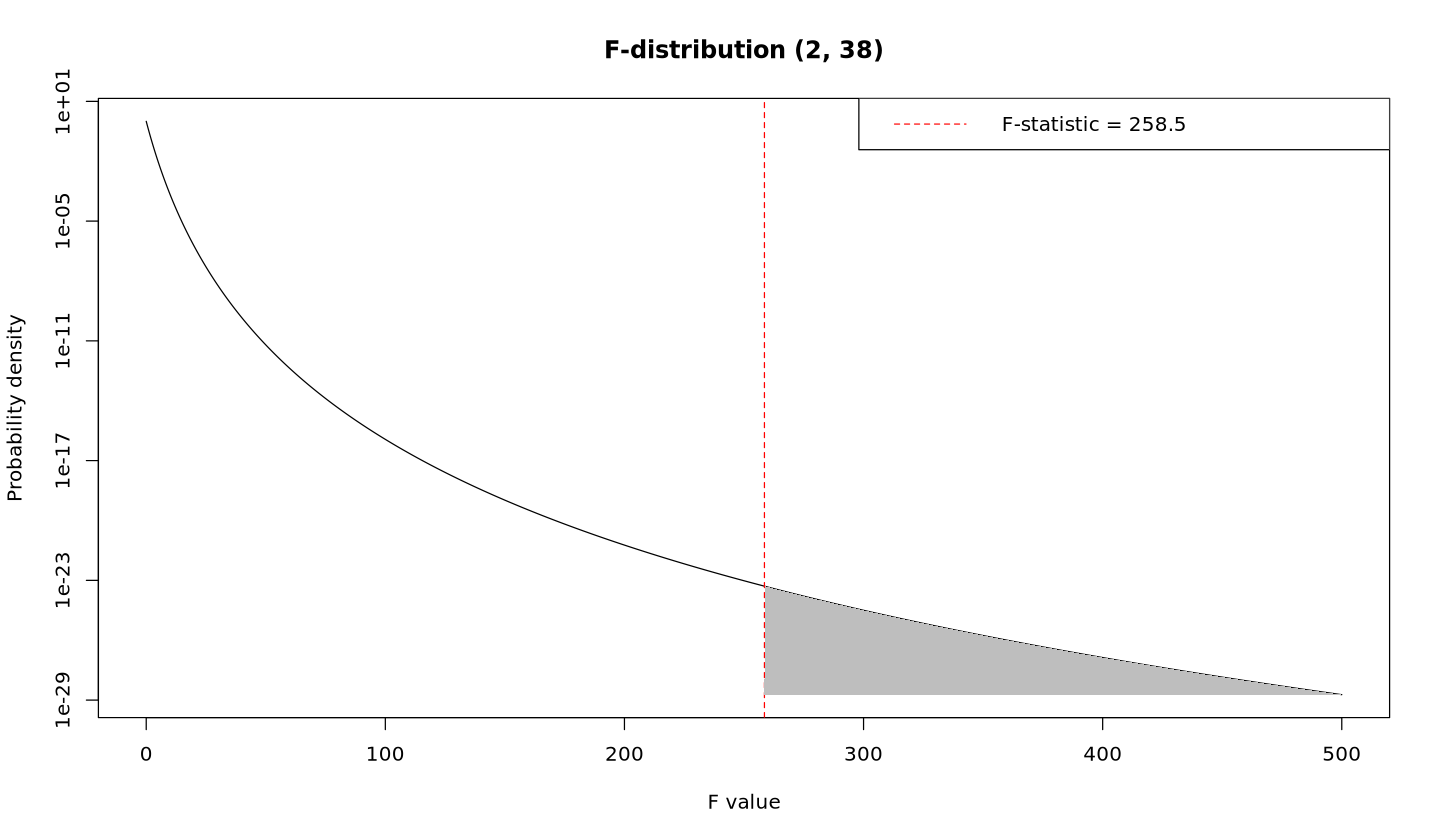

In [29]:
# Plot the F-distribution
x <- seq(0, 500, length.out = 1000)
y <- df(x, dof1, dof2)

plot(x, y, type = "l", main = sprintf("F-distribution (%.0f, %.0f)", dof1, dof2), 
     xlab = "F value", ylab = "Probability density", log="y")
abline(v = Fstat, col = "red", lty = 2)
polygon(c(Fstat, x[x >= Fstat]), c(min(y[y>0]), y[x >= Fstat]), col = "gray", border = NA)
legend("topright", legend = sprintf("F-statistic = %.1f", Fstat), col = "red", lty = 2)

### Sphericity

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'


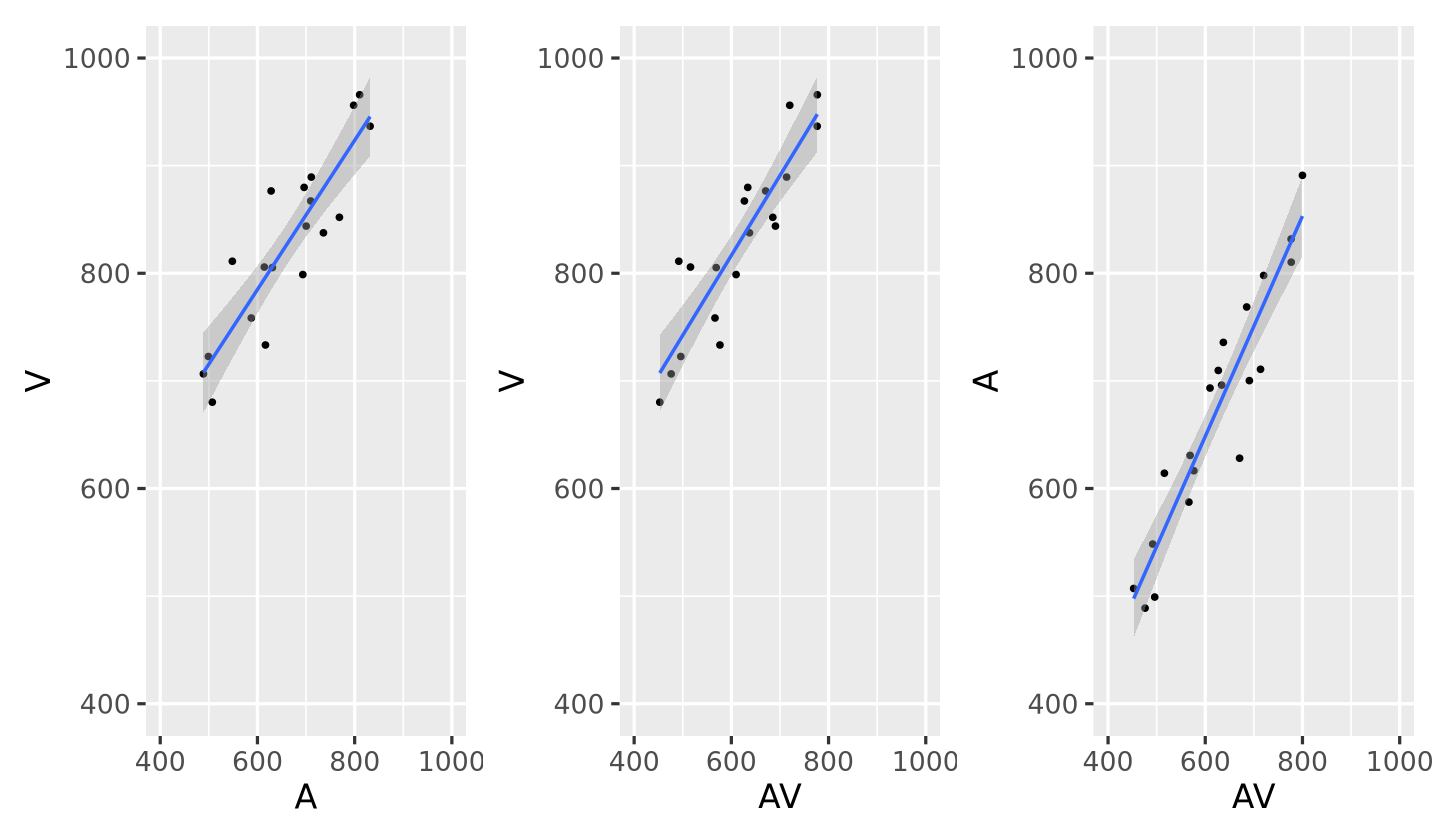

In [25]:
# # Create a new table indicating pairings of conditions
# paired_cond <- spread(df, Condition, Response_time)
# pairs <- list(c("A", "V"), c("AV", "V"), c("AV", "A"))

# par(mfrow = c(1, 3))
# for (pair in pairs) {
#   plot(paired_cond[[pair[1]]], paired_cond[[pair[2]]], xlab = pair[1], ylab = pair[2], xlim = c(400, 1000), ylim = c(400, 1000))
#   abline(lm(paired_cond[[pair[2]]] ~ paired_cond[[pair[1]]]), col = "blue")
# }

# Reshape data from long to wide format
paired_cond <- pivot_wider(df, 
                          id_cols = Subject, 
                          names_from = Condition, 
                          values_from = Response_time)

# Create the three scatter plots with regression lines
p1 <- ggplot(paired_cond, aes(x = A, y = V)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  xlim(400, 1000) +
  ylim(400, 1000) +
  theme_gray(base_size=20)

p2 <- ggplot(paired_cond, aes(x = AV, y = V)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  xlim(400, 1000) +
  ylim(400, 1000) +
  theme_gray(base_size=20)

p3 <- ggplot(paired_cond, aes(x = AV, y = A)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  xlim(400, 1000) +
  ylim(400, 1000) +
  theme_gray(base_size=20)

# Combine plots side by side
p1 + p2 + p3

In [21]:
# Variability in the difference between conditions
diff_cond <- data.frame(
  `V-A` = paired_cond$V - paired_cond$A,
  `V-AV` = paired_cond$V - paired_cond$AV,
  `A-AV` = paired_cond$A - paired_cond$AV
)
print(diff_cond)
# This automatically changes the minus signs to ., - is not allowed here

         V.A     V.AV       A.AV
1  158.09203 235.9268  77.834797
2  101.81457 200.3440  98.529395
3  179.45327 270.4808  91.027513
4  173.07815 227.4422  54.364023
5  262.81741 319.2971  56.479655
6  191.59776 289.8795  98.281732
7  104.82319 160.0192  55.195992
8  157.48162 240.3450  82.863350
9   83.34109 166.7575  83.416445
10 223.50991 226.6109   3.100998
11 105.45396 189.0306  83.576616
12 217.66483 230.3385  12.673664
13 116.82707 156.8154  39.988321
14 155.60370 189.0095  33.405840
15 248.33919 205.8515 -42.487689
16 174.53739 236.4352  61.897795
17 171.07974 192.0789  20.999165
18 178.58798 175.6681  -2.919913
19 183.71476 246.0356  62.320836
20 143.57986 153.0935   9.513683


No id variables; using all as measure variables



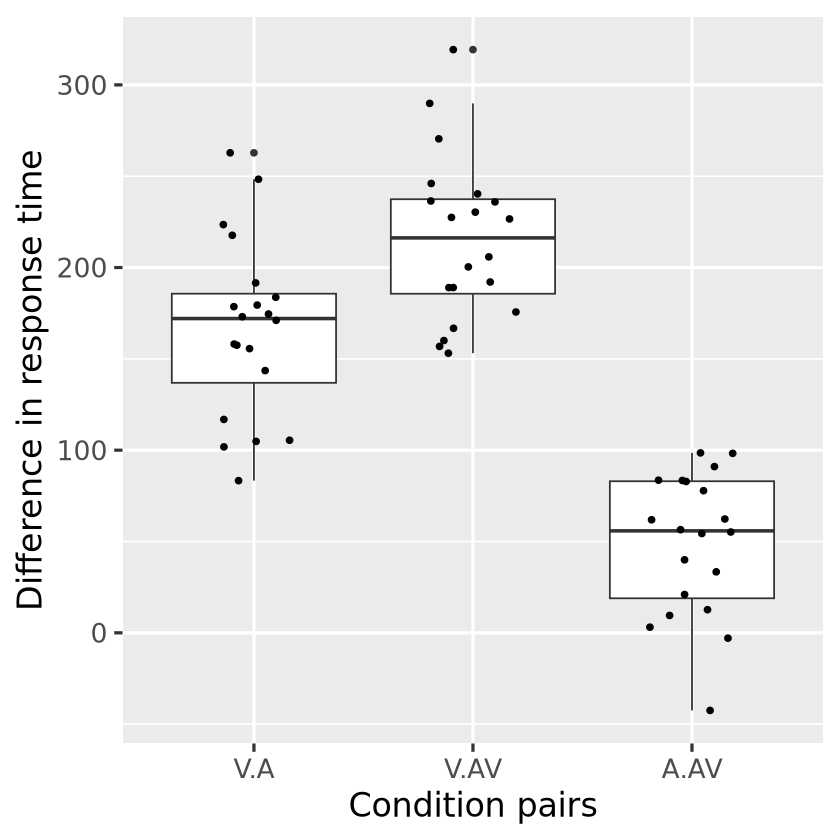

In [22]:
# Plot the difference between conditions with a box-whisker plot
ggplot(melt(diff_cond), aes(x = variable, y = value)) +
  geom_boxplot() +
  geom_jitter(width = 0.2) +
  labs(x = "Condition pairs", y = "Difference in response time") +
  theme_gray(base_size=20)

In [54]:
# Mauchly's test for sphericity
sphericity_test <- summary_aov$sphericity.tests
cat(sprintf("Mauchly's sphericity test: W = %.3f, p = %.3f",
           sphericity_test[1,'Test statistic'],sphericity_test[1,'p-value']))

Mauchly's sphericity test: W = 0.935, p = 0.544

### Multiple comparisons

In [56]:
# Multiple comparisons
emmeans_results <- emmeans(anova_results, pairwise ~ Condition, adjust="bonf")
print(emmeans_results$contrasts)

 contrast estimate    SE df t.ratio p.value
 A - AV         49  8.68 19   5.645  0.0001
 A - V        -167 10.89 19 -15.289  <.0001
 AV - V       -216 10.11 19 -21.314  <.0001

P value adjustment: bonferroni method for 3 tests 
